# Molecular mass 2

*24 Mar 2020*

This time we will use the full survey data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from astropy import units as u
from astropy import constants as c

In [18]:
from scipy.optimize import curve_fit, fsolve

from functions import single_gaussian, double_gaussian

In [3]:
## Constants ##
rsun = 8.34 # kpc
vsun = 240 # km/s

First we read in our data.

In [4]:
## Read our data ##
## columns are: radius (kpc), WCO (K km/s), WCO err (K Km/s)
## (generated in wco.ipynb)

our_data = np.loadtxt('mcmc_files/molecular_mass_data.txt')

our_radii = our_data[:,0]
our_radii

array([7.99985611, 7.49976681, 7.00005677, 6.49967863, 6.02149491,
       5.5000384 , 5.00051779, 4.49947802, 3.99995588, 3.49955168,
       2.99965717, 2.49955559, 2.00067579])

Then we read in the survey data. This full survey has a lot more points, so we first need to figure out which radii in this survey are relevant to us.

In [5]:
## Read survey_data ##
## columns are: longitude (deg), latitude (deg), WCO (K km/s)

survey_data = np.loadtxt('survey_files/Vsub_pm20_Wco.txt')

In [6]:
survey_radii = rsun * np.sin(np.pi/180*survey_data[:,0])

In [7]:
def floateq(a1, a2, eps=1e-5):
    # more robust than asking a1 == a2 in case of rounding errors 
    return abs(a1-a2) < eps

In [53]:
our_survey_radii = [] # best matches for our radii
our_survey_idxs = []
for our_radius in our_radii:
    # idx of 
    idx = np.argmin(abs(survey_radii - our_radius))
    survey_radius = survey_radii[idx]
    idxs = np.where(floateq(survey_radii, survey_radius))[0]
    
    our_survey_idxs.append(idxs)
    our_survey_radii.append(survey_radius)
    
our_survey_radii = np.array(our_survey_radii)
print(our_survey_radii)
print(our_survey_idxs)

[8.00170523 7.49594235 7.00440562 6.50423659 6.02451544 5.4989441
 5.00459414 4.49641361 3.99548471 3.49162221 3.00576812 2.50788637
 1.99996924]
[array([363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 391, 392, 393, 394, 395]), array([2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914,
       2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925,
       2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936]), array([4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729,
       4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740,
       4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751]), array([6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280,
       6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291,
       6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302]), ar

In [9]:
our_survey_idxs[0]

array([363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 391, 392, 393, 394, 395])

## Quick fit

radius 8.001705229829017 long 73.625


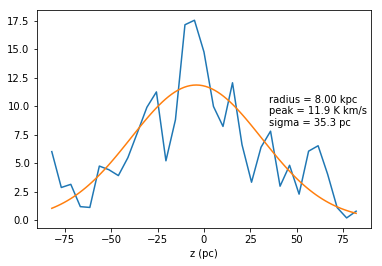

radius 7.495942346135053 long 64.00000000000001


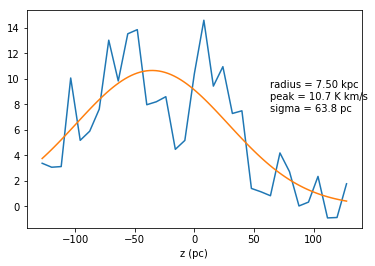

radius 7.00440562163707 long 57.125


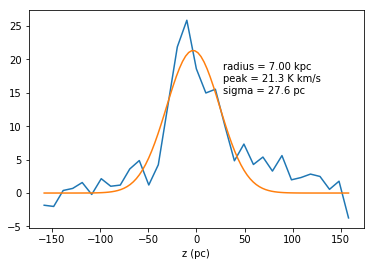

radius 6.504236588994633 long 51.24999999999999


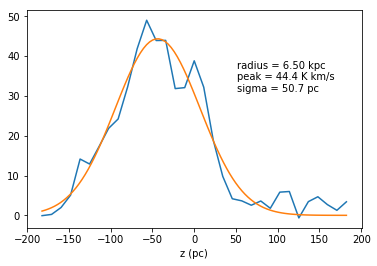

radius 6.024515443578361 long 46.25


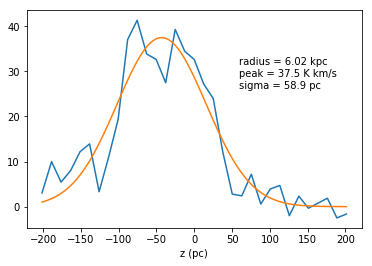

radius 5.498944097934574 long 41.25


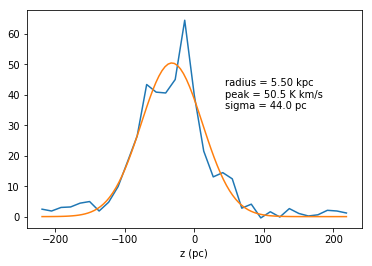

radius 5.0045941409701715 long 36.875


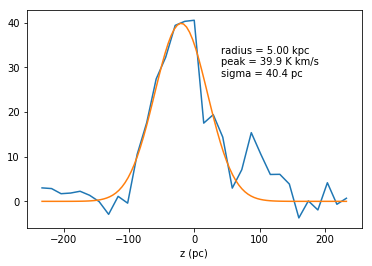

radius 4.496413613077741 long 32.625


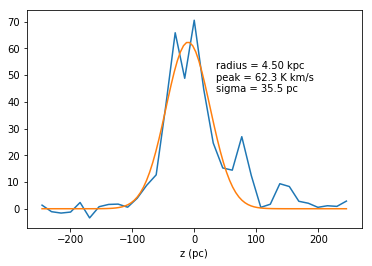

radius 3.995484705221405 long 28.625


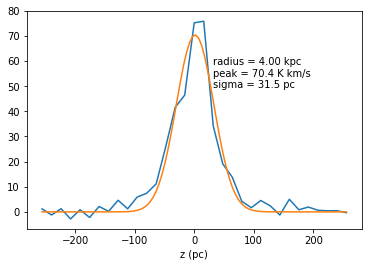

radius 3.49162221106215 long 24.75


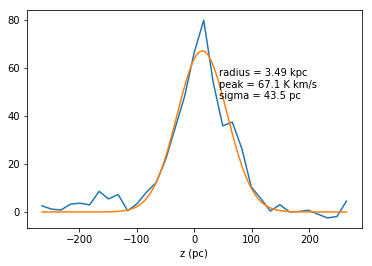

radius 3.0057681224419905 long 21.125


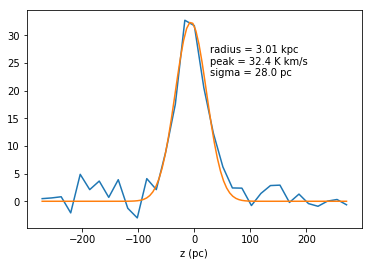

radius 2.5078863678656376 long 17.5


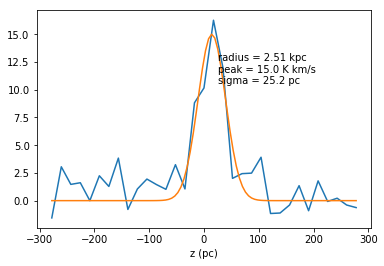

radius 1.999969235222838 long 13.875


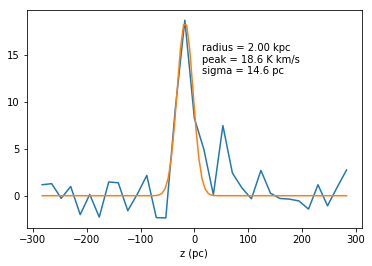

In [30]:
peaks = [] # K km/s
sigmas = [] # kpc

for radius, idxs in zip(our_survey_radii, our_survey_idxs):
    print('radius', radius, 'long', 180/np.pi*np.arcsin(radius/rsun))
    b_list = survey_data[idxs,1]
    z_list = b_list * np.pi/180 * np.sqrt(rsun**2 - radius**2)
    wco_list = survey_data[idxs,2]
    plt.plot(z_list * 1e3, wco_list)
    
    popt, pcov = curve_fit(single_gaussian, z_list, wco_list)
    z_all = np.linspace(min(z_list),max(z_list),100)
    plt.plot(z_all * 1e3, single_gaussian(z_all, *popt))
    
    peaks.append(popt[2])
    sigmas.append(abs(popt[1]))
    
    plt.text(1e3*abs(popt[1]), .7*popt[2], 'radius = {0:.2f} kpc\npeak = {1:.1f} K km/s\nsigma = {2:.1f} pc '.format(radius, popt[2], 1e3*abs(popt[1])))

#     try:
#         popt2, _ = curve_fit(double_gaussian, b_list, wco_list)
#         b_all = np.linspace(-2,2,100)
#         plt.plot(b_all, double_gaussian(b_all, *popt2))
#     except RuntimeError:
#         print('Runtime error fitting double_gaussian')
    
    plt.xlabel('z (pc)')
    plt.show()
    
peaks = np.array(peaks)
sigmas = np.array(sigmas)

## Getting a mass from the quick fits
First we need a convenience-fit for $\Omega(r)$.

In [12]:
rot_data = np.loadtxt('mcmc_files/rotcurve_data.txt')

rot_radii = rot_data[:,0]
vmean_list = rot_data[:,1] # subtracted off v_circ already
vmean_err_list = rot_data[:,2]

omega_list = vmean_list / rot_radii
omega_err_list = vmean_err_list / rot_radii

In [13]:
def omegafit(r, a, b):
    return a * r**(-b)

In [14]:
popt_omega, _ = curve_fit(omegafit, rot_radii, omega_list)

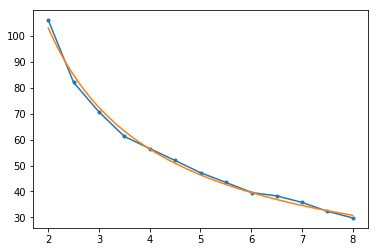

In [15]:
plt.plot(rot_radii, omega_list, '.-')
radii_all = np.linspace(2,8,100)
plt.plot(radii_all, omegafit(radii_all, *popt_omega))

TODO: replace the above with MCMC.

In [16]:
omega_primes = (vmean_list - 20) / rot_radii

In [17]:
omega_primes

array([27.31445211, 29.73034139, 32.94408748, 35.23114368, 36.21699135,
       39.85871924, 43.23548113, 47.49026017, 51.51472921, 55.4803989 ,
       63.9643328 , 73.98501486, 95.95677858])

In [22]:
r_primes = np.array([fsolve(lambda r: omegafit(r, *popt_omega)-omega_prime, rad)[0] for omega_prime, rad in zip(omega_primes, rot_radii)])

In [40]:
wco_lengths = 2*np.sqrt(r_primes**2 - rot_radii**2)
wco_lengths_cm = wco_lengths * (1*u.kpc/u.cm).si

x_factor = 2e20 / .82 # but not the extra 90% factor that we had when we were taking data (?)
num_dens_h2_list = x_factor * peaks / wco_lengths_cm # cm^-3

disk_widths = sigmas * np.sqrt(2*np.pi) # kpc
mass_h2 = 2*8.35e-58 # H2 molecule in solar masses
surface_densities = num_dens_h2_list * disk_widths * mass_h2 * (1*u.kpc/u.cm**3).to(u.pc**-2).value

Text(0, 0.5, 'Surface density ($M_\\odot$ / pc$^2$)')

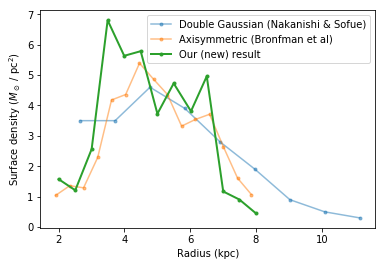

In [50]:
published_data_2gauss = np.array([[2.6600,3.5000 ],
[3.7200,3.5000 ],
[4.7800,4.6000 ],
[5.8400,3.9000 ],
[6.9100,2.8000 ],
[7.9700,1.9000 ],
[9.0300,0.90000],
[10.090,0.50000],
[11.160,0.30000]])

published_data_axisymmetric = np.array([[1.9100, 1.0400],
[2.3400, 1.3600],
[2.7600, 1.2900],
[3.1900, 2.2900],
[3.6100, 4.1800],
[4.0400, 4.3600],
[4.4600, 5.3900],
[4.8900, 4.8600],
[5.3100, 4.3600],
[5.7400, 3.3200],
[6.1600, 3.5400],
[6.5900, 3.7100],
[7.0100, 2.6400],
[7.4400, 1.6100],
[7.8600, 1.0700]])

plt.plot(published_data_2gauss[:,0], published_data_2gauss[:,1], '.-', alpha=.5, label='Double Gaussian (Nakanishi & Sofue)')
plt.plot(published_data_axisymmetric[:,0], published_data_axisymmetric[:,1], '.-', alpha=.5, label='Axisymmetric (Bronfman et al)')

plt.plot(our_survey_radii, surface_densities, '.-', linewidth=2, label='Our (new) result')

plt.legend()

plt.xlabel('Radius (kpc)')
plt.ylabel('Surface density ($M_\\odot$ / pc$^2$)')

In [60]:
dr = 0.5 # kpc
total_mass = np.sum(2*np.pi*our_survey_radii * dr * surface_densities) * (1*u.kpc/(1*u.pc)).si**2

In [63]:
total_mass

<Quantity 6.42768124e+08>

In [53]:
sigmas

[0.03529452182967025,
 0.06375817522938891,
 0.027556871496844333,
 0.050734069526261624,
 0.058936172769256064,
 0.04398778293658847,
 0.040383607894140444,
 0.035545662388506157,
 0.031514539724407674,
 0.04345860565928338,
 0.027952759477257543,
 0.025187433086769278,
 0.01463512541786246]

In [54]:
our_survey_radii

[8.001705229829017,
 7.495942346135053,
 7.00440562163707,
 6.504236588994633,
 6.024515443578361,
 5.498944097934574,
 5.0045941409701715,
 4.496413613077741,
 3.995484705221405,
 3.49162221106215,
 3.0057681224419905,
 2.5078863678656376,
 1.999969235222838]